In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import re
import os
import glob
from pathlib import Path
import json
from shutil import copyfile
import itertools
from collections import Counter

# analytics
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
# Spacy Imports
import spacy

from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs

def display_ent(doc):
    displacy.render(doc, style="ent", jupyter=True)

spacy_model = "en_core_web_lg"

nlp = spacy.load(spacy_model)

In [99]:
# User Source Code

import utilsCharlie

In [100]:
# Project Base
base_path = Path('..')

# Data Paths
data_path = base_path / 'data'
all_reports_path = data_path / 'wamex_xml'
subset_reports_path = data_path / 'subset'
test_reports_path = data_path / 'testset'

# Event Path
events_path = base_path / 'events'

# Dictionary Paths
dictionary_path = base_path / 'dictionary'
triggers_path = dictionary_path / 'triggers'
patterns_path = dictionary_path / 'patterns'

# NLP

## Load Match Pattern Pipelines

In [101]:
patterns = []
for filename in patterns_path.iterdir():
    with open(filename, encoding="utf8") as f:
        patterns += json.load(f)
        
print(f'loaded {len(patterns)} patterns')

loaded 31120 patterns


In [102]:
patterns[:5]

[{'label': 'ROCK',
  'pattern': [{'LOWER': 'acapulcoite'}, {'LOWER': 'meteorite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'aceite'}]},
 {'label': 'ROCK',
  'pattern': [{'LOWER': 'acid'}, {'LOWER': 'volcanic'}, {'LOWER': 'rock'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adakite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adamellite'}]}]

## Add patterns to nlp

In [103]:
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)

nlp.add_pipe(ruler)

## Load Trigger Words

In [104]:
trigger_words = []
for filename in triggers_path.iterdir():
    with open(filename, 'r') as f:
        trigger_words += [w.strip() for w in f.readlines()]
    
print(f'loaded {len(trigger_words)} trigger words\n')
print(trigger_words)

loaded 25 trigger words

['potential', 'drill', 'drilling', 'mineralisation', 'contain', 'promise', 'find', 'possible', 'enrich', 'enrichment', 'subeconomic', 'encouraging', 'extensive', 'patchy', 'minor', 'further drilling', 'low grade', 'medium grade', 'follow up', 'weak intercepts', 'minor intercepts', 'open at depth', 'along strike', 'exploration licence', 'prospective']


# Load Trigger Phrases/Words into Spacy PhraseMatcher


In [105]:
triggerPhrase = dictionary_path / 'trigger phrases'
near_miss_phrases =[]
for filename in triggerPhrase.iterdir():
    with open(filename, 'r') as f:
        for line in f:
            if len(line) > 1:
                near_miss_phrases.append(line[:-2].split())
f.close()

## Geology ent's to extract

In [106]:
geology_ents = ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']

# Event Extraction

In [112]:
from utilsCharlie import create_event_df

eventdf = create_event_df(
    nlp=nlp, 
    directory=subset_reports_path, 
    trigger_phrases = near_miss_phrases, 
    geology_ents=geology_ents,
    n_sentences_extact=2,
)


extracting events on 7 files
found 30 events from a total of 462 sentences


In [113]:
eventdf.head()

,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words,event_text,ORE_DEPOSIT,ROCK,MINERAL,STRAT,LOCATION,TIMESCALE,event_label
0,a070455_partial surrender report e59-907_97711...,a070455_partial surrender report e59-907_97711...,39,2004: the nickel pge potential of the narndee ...,1,[potential],"ahmat a.l., de laeter j.r. 1982: rb sr isotope...",[pge],"[gabbroid, gabbronorites, gabbroid]",[nickel],[],"[yilgarn block, western australia, windimurra,...","[archaean, proterozoic]",0
1,a070455_partial surrender report e59-907_97711...,a070455_partial surrender report e59-907_97711...,58,the narndee and mulyeron hill areas are interp...,2,"[potential, mineralisation]",figure 1 project location plan figure 2 teneme...,[pge],"[lag, gabbro, anorthosite, pyroxenite, peridot...","[nickel, sulphide, nickel, sulphide]",[],"[windimurra, mulyeron hill]",[],0
2,a070455_partial surrender report e59-907_97711...,a070455_partial surrender report e59-907_97711...,59,the area to be relinquished does not appear to...,1,[mineralisation],the narndee and windimurra intrusive complexes...,[pge],"[gabbro, anorthosite, pyroxenite, peridotite, ...","[nickel, sulphide, nickel, sulphide]",[],"[windimurra, mulyeron hill]",[],0
3,a070455_partial surrender report e59-907_97711...,a070455_partial surrender report e59-907_97711...,76,the area was selected for potential nickel cop...,2,"[potential, mineralisation]",the project is being managed by wmc in joint v...,[pge],[],"[nickel, copper]",[],"[windimurra, windimurra]",[],0
4,a070682_a70682_9855451_16,a070682_a70682_9855451.json,16,"furthermore extensive costeaning, rab and rc d...",1,[extensive],during site visits it become evident that the ...,[],[],[gold],[],[central west],[],0


## Save Events to csv file

In [71]:
event_path = events_path / 'group_0_events.csv'
eventdf.to_csv(event_path, index=False)

# Visualisations

## Frequency of number of trigger words found in each event

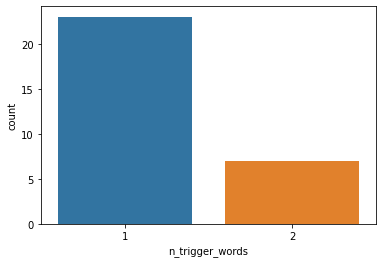

In [72]:
sns.countplot(eventdf.n_trigger_words);

## Count of each trigger word found

In [73]:
from utils import get_feature_counts_df

In [74]:
feature = 'trigger_words'
get_feature_counts_df(eventdf, feature)

,count
trigger_words,
mineralisation,26
potential,4
possible,4
extensive,2
enriched,1


In [75]:
feature = 'ORE_DEPOSIT'
get_feature_counts_df(eventdf, feature)

,count
ORE_DEPOSIT,
lode,6
pge,4
base metal,4
lodes,2
copper ore,1


In [76]:
feature = 'STRAT'
get_feature_counts_df(eventdf, feature)

,count
STRAT,
ularring granite,1
sharks formation,1


In [77]:
feature = 'TIMESCALE'
get_feature_counts_df(eventdf, feature)

,count
TIMESCALE,
archaean,1
proterozoic,1


In [78]:
feature = 'LOCATION'
get_feature_counts_df(eventdf, feature)

,count
LOCATION,
windimurra,7
long,7
hammerhead zone,5
pilbara,4
western australia,3
australia,3
callion,3
mulyeron hill,2
davyhurst,2


# Ent Test

In [79]:
example = nlp(eventdf.iloc[0]['event_text'])
display_ent(example)

In [80]:
for ent in example.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

ahmat a.l. 0 10 PERSON
de laeter j.r. 12 26 PERSON
1982 27 31 DATE
archaean 60 68 TIMESCALE
proterozoic 69 80 TIMESCALE
yilgarn block 122 135 LOCATION
western australia 137 154 LOCATION
windimurra 210 220 LOCATION
gabbroid 221 229 ROCK
j.l. 238 242 GPE
lipple 244 250 GPE
s.l. 252 256 GPE
marston 258 265 PERSON
1983 272 276 DATE
kirkalocka 278 288 PERSON
western australia 290 307 LOCATION
gswa bunting j.a. 370 387 PERSON
2004 388 392 DATE
nickel 398 404 MINERAL
pge 405 408 ORE_DEPOSIT
windimurra 438 448 LOCATION
apex 474 478 ORG
nl matheson c.i 488 503 PRODUCT
r. a. 511 516 PERSON
1990 517 521 DATE
gabbronorites 549 562 ROCK
windimurra 570 580 LOCATION
gabbroid 581 589 ROCK
western australia 599 616 LOCATION


In [58]:
minerals = [ent.text for ent in example.ents if ent.label_ == 'MINERAL']
minerals

['gold']